### Political Polarization Calculations using BHPS 2004 data

In [22]:
import pandas as pd
import os
import time
import numpy as np

In [23]:
os.chdir(r"C:\Users\Sidrcs\Documents\Github\Political_Polarization\data")

Download data from <a href = "https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5151#!/access-data"> UK data service </a> website. The data would be in <b> SPSS </b> format. To read and convert these files, use <code> pip install pyreadstat </code> and then use <code> df = pd.read_spss("file path") </code>. Convert the dataframe to CSV using <code> df.to_csv("file.csv") </code>. 

In [24]:
# Each year has a {string}indresp.csv combination
df_residence = pd.read_csv("nindresp.csv")

C:\Users\Sidrcs\anaconda3\envs\PySAL\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (8,9,29,928,929,1047,1158,1276,1278,1281) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Interested variables for visualization
Look for <code>nindresp.csv</code>. Required variables are: (These are columns names and their corresponding interpretation) <ul><li><code>nopsocc</code> : "Private enterprise is the best way to solve Britain’s economic problems" (S1)</li> <li><code>nopsocd</code> : "Major public services and industries ought to be in state ownership" (S2)</li> <li><code>nopsoce</code> : "It is the government’s responsibility to provide a job for everyone who wants one" (S3)</li> <li><code>nfiyr</code> : <b>Self-reported annual income</b> </li> <li><code>nfetype</code> : <b>Educational qualification</b></li> <li><code>nplbornc_cc</code> : <b>Country of birth</b></li> <li><code>nage12</code> : <b>Age</b></li> <li><code>njbstatt</code> : <b>Employment status</b></li> <li><code>nregion2</code> : <b>UK region name</b> </li></ul>

In [25]:
# Loading variables of interest from 2004 BHPS dataset into dataframe
df_residence = df_residence[["nopsocc","nopsocd","nopsoce","nfiyr","nfetype","nage12","njbstatt","nregion2", "nplbornc_cc"]]

In [26]:
# Dropping rows that donot have any spatial information associated with them
df_residence = df_residence[~df_residence["nregion2"].isin(["don't know", "inapplicable", "missing or wild", "refused"])]

In [27]:
# To view columns
df_residence.head()

,nopsocc,nopsocd,nopsoce,nfiyr,nfetype,nage12,njbstatt,nregion2,nplbornc_cc
0,Strongly agree,Disagree,Disagree,45694.3984375,inapplicable,70.0,Retired,London,inapplicable
1,Agree,Disagree,Disagree,12363.2216796875,inapplicable,67.0,Retired,London,inapplicable
2,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,23.0,proxy and/or phone,London,proxy and/or phone
3,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,49.0,proxy and/or phone,London,proxy and/or phone
4,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,23.0,proxy and/or phone,London,proxy and/or phone


In [28]:
# checking different types of opinions provided for statement when surveyed
df_residence['nopsocc'].value_counts()

Neither agree/disagree    6581
Disagree                  3646
Agree                     2817
proxy and/or phone        1013
don't know                 683
Strongly disagree          599
Strongly agree             387
refused                      3
missing or wild              1
Name: nopsocc, dtype: int64

In [29]:
# create an empty dataframe
output_df = pd.DataFrame()

# Group the dataframe by county and calculate standard deviation of age : "nage12"
output_df["std_dev_age"] = df_residence.groupby("nregion2")["nage12"].agg("std")

# Group the dataframe by county and number of people born in UK : "nplbornc_cc"
output_df["born"] = df_residence.groupby("nregion2")["nplbornc_cc"]

# Assuming inapplicable as people born in UK to all others
def native_share(x):
    pop_count = list(x["born"][1])
    native_count = pop_count.count("inapplicable")/len(pop_count)
    return native_count

# calculating fraction of natives in each county
output_df["native_share"] = output_df.apply(lambda x: native_share(x), axis = 1)

# Dropping "born" groupby column
output_df = output_df.drop(columns = ["born"], axis = 1)

# Creating afetype_dict based on PDF from 2004 BHPS data
nfetype_dict = {"Nursing school etc" : 1, "College of f educ" : 2, "Other trng establmnt" : 3, "Polytechnic" : 4, \
                "University" : 5, "None of the above" : 7, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy and/or phone" : -7, "refused" : -2}


# Create a new column "nfetype_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nfetype_encoded"] = df_residence["nfetype"].replace(nfetype_dict)

# Group the dataframe by county and "nfetype_encoded"
output_df["education"] = df_residence.groupby("nregion2")["nfetype_encoded"]

# function to calculate dissimilarity in education
def dissimilarity_education(x):
    # loads tuple element into job
    job = x["education"][1]
    # loads frequency of each education type in county as list
    freq = list(job.value_counts())
    # calculates total number of groups
    s = len(freq)
    dissim_index = 0
    for i in freq:
        # formula of dissimilarity index
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

def region_name(x):
    return x["education"][0]

output_df["education_variability"] = output_df.apply(lambda x: dissimilarity_education(x), axis = 1)
output_df["region_name"] = output_df.apply(lambda x: region_name(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["education"], axis = 1)

# Creating ajbstatt_dict based on PDF from 2000 BHPS data
njbstatt_dict = {"Self employed" : 1, "In paid employ" : 2, "Unemployed" : 3, "Retired" : 4, "Maternity leave" : 5, \
                    "Family care" : 6,  "FT studt, school" : 7, " LT sick, disabld" : 8, \
                    "Govt trng scheme" : 9, "Something else" : 10, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy" : -7, "refused" : -2}


# Create a new column "ajbstatt_encoded" in the dataframe by replacing the values with encoded values from the dictionary
#df_residence.loc["njbstatt_encoded"] = df_residence["njbstatt"].replace(njbstatt_dict)
df_residence.loc[:, "njbstatt_encoded"] = df_residence["njbstatt"].replace(njbstatt_dict)

# Group the dataframe by county and calculate the mean and standard deviation of the encoded values
output_df["job"] = df_residence.groupby("nregion2")["njbstatt_encoded"]

# function to calculate dissimilarity in job
def dissimilarity_job(x):
    job = x["job"][1]
    freq = list(job.value_counts())
    s = len(freq)
    dissim_index = 0
    for i in freq:
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

# function to calculate fraction of employed people within each county
def frac_employed(x):
    job = list(x["job"][1])
    frac_emp = (job.count(2)/len(job))
    return frac_emp

output_df["job_variability"] = output_df.apply(lambda x: dissimilarity_job(x), axis = 1)
output_df ["frac_employed"] = output_df.apply(lambda x: frac_employed(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["job"], axis = 1)

# replacing all Not-A-Number cases to zero i.e., proxy values
df_residence.loc[:, "nfiyr"] = df_residence["nfiyr"].replace("proxy and/or phone",0).astype("float32")

# Group the dataframe by county and calculate median based on self-reported annual income: "nfiyr"
output_df["median_income"] = df_residence.groupby("nregion2")["nfiyr"].agg(["median"])

# convert "afiyr" column to float data type
df_residence["nfiyr"] = df_residence["nfiyr"].astype("float32")

# group incomes by county
output_df["income"] = df_residence.groupby("nregion2")["nfiyr"]

def gini_index(x):
    data = list(x["income"][1])
    # sort the data in ascending order
    sorted_data = np.sort(data)
    # calculate the cumulative sum of the sorted data
    cumsum_data = np.cumsum(sorted_data)
    # calculate the Lorenz curve values
    lorenz_curve = cumsum_data / cumsum_data[-1]
    # calculate the area under the Lorenz curve
    area_lorenz_curve = np.trapz(lorenz_curve, dx=1/len(data))
    # calculate the Gini index
    gini_index = 1 - 2 * area_lorenz_curve
    return gini_index

output_df["gini_index"] = output_df.apply(lambda x : gini_index(x), axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["income"], axis = 1)

output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index
nregion2,,,,,,,,
Channel Islands,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804
East Midlands,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949
East of England,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209
London,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331
North East,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723
North West,18.935736,0.941230,552.5,North West,552.5,0.508137,10917.675781,0.468179
Northern Ireland,18.325703,0.967194,1295.0,Northern Ireland,1295.0,0.426862,10157.713867,0.456657
Scotland,18.028724,0.922806,1418.0,Scotland,1418.0,0.487134,10570.116211,0.472727
South East,18.359198,0.931727,622.0,South East,622.0,0.525301,12449.538086,0.481282


In [30]:
# Define the dictionary to encode the "nopsocc" column which is Statement 1 (S1) by keeping valid statement only
# S1: "Private enterprise is the best way to solve Britain’s economic problems."
nopsocc_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "nopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nopsocc_encoded"] = df_residence["nopsocc"].replace(nopsocc_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['nopsocc_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S1"] = df_residence.groupby("nregion2")["nopsocc_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("nregion2")["nopsocc_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("nregion2")["nopsocc_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S1"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and nopsocc_encoded values
output_df["dkp"] = df_residence.groupby("nregion2")["nopsocc_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S1"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1
nregion2,,,,,,,,,,,
Channel Islands,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,125.000000
East Midlands,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,2.410976
East of England,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,2.233210
London,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,4.491054
North East,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,0.292814
North West,18.935736,0.941230,552.5,North West,552.5,0.508137,10917.675781,0.468179,0.781323,0.639029,1.963049
Northern Ireland,18.325703,0.967194,1295.0,Northern Ireland,1295.0,0.426862,10157.713867,0.456657,0.763254,0.610368,2.478284
Scotland,18.028724,0.922806,1418.0,Scotland,1418.0,0.487134,10570.116211,0.472727,0.719986,0.612326,0.853648
South East,18.359198,0.931727,622.0,South East,622.0,0.525301,12449.538086,0.481282,0.644165,0.546679,0.893705


In [31]:
# Define the dictionary to encode the "nopsocd" column which is Statement 2 (S2)
# S2: "Major public services and industries ought to be in state ownership."

jopsocd_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "nopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nopsocd_encoded"] = df_residence["nopsocd"].replace(jopsocd_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['nopsocd_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S2"] = df_residence.groupby("nregion2")["nopsocd_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("nregion2")["nopsocd_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("nregion2")["nopsocd_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S2"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and nopsocc_encoded values
output_df["dkp"] = df_residence.groupby("nregion2")["nopsocd_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S2"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

In [32]:
# Define the dictionary to encode the "nopsocd" column which is Statement 3 (S3)
# S3: "It is the government’s responsibility to provide a job for everyone who wants one."

nopsoce_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "jopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nopsoce_encoded"] = df_residence["nopsoce"].replace(nopsoce_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['nopsoce_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S3"] = df_residence.groupby("nregion2")["nopsoce_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("nregion2")["nopsoce_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("nregion2")["nopsoce_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S3"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and nopsocc_encoded values
output_df["dkp"] = df_residence.groupby("nregion2")["nopsoce_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S3"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
nregion2,,,,,,,,,,,,,,,,,
Channel Islands,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,125.000000,4.500000,1.500000,375.000000,0.500000,1.500000,125.000000
East Midlands,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,2.410976,0.891563,0.706147,2.305031,1.168530,0.912782,8.061817
East of England,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,2.233210,0.840264,0.697047,1.117012,1.013606,0.854942,2.416369
London,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,4.491054,0.995649,0.782875,3.072200,1.276732,0.966102,9.327323
North East,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,0.292814,0.882639,0.706897,3.139223,1.028232,0.890173,1.449022
North West,18.935736,0.941230,552.5,North West,552.5,0.508137,10917.675781,0.468179,0.781323,0.639029,1.963049,0.957699,0.750257,5.333168,1.201915,0.942268,8.285364
Northern Ireland,18.325703,0.967194,1295.0,Northern Ireland,1295.0,0.426862,10157.713867,0.456657,0.763254,0.610368,2.478284,0.955308,0.742072,4.563541,1.227427,0.977994,3.223163
Scotland,18.028724,0.922806,1418.0,Scotland,1418.0,0.487134,10570.116211,0.472727,0.719986,0.612326,0.853648,0.870811,0.710292,2.119109,1.149324,0.937805,3.620101
South East,18.359198,0.931727,622.0,South East,622.0,0.525301,12449.538086,0.481282,0.644165,0.546679,0.893705,0.873665,0.740236,1.037948,1.110175,0.902372,5.759079


In [33]:
output_df.reset_index(drop=True, inplace=True)
output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,125.000000,4.500000,1.500000,375.000000,0.500000,1.500000,125.000000
1,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,2.410976,0.891563,0.706147,2.305031,1.168530,0.912782,8.061817
2,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,2.233210,0.840264,0.697047,1.117012,1.013606,0.854942,2.416369
3,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,4.491054,0.995649,0.782875,3.072200,1.276732,0.966102,9.327323
4,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,0.292814,0.882639,0.706897,3.139223,1.028232,0.890173,1.449022
5,18.935736,0.941230,552.5,North West,552.5,0.508137,10917.675781,0.468179,0.781323,0.639029,1.963049,0.957699,0.750257,5.333168,1.201915,0.942268,8.285364
6,18.325703,0.967194,1295.0,Northern Ireland,1295.0,0.426862,10157.713867,0.456657,0.763254,0.610368,2.478284,0.955308,0.742072,4.563541,1.227427,0.977994,3.223163
7,18.028724,0.922806,1418.0,Scotland,1418.0,0.487134,10570.116211,0.472727,0.719986,0.612326,0.853648,0.870811,0.710292,2.119109,1.149324,0.937805,3.620101
8,18.359198,0.931727,622.0,South East,622.0,0.525301,12449.538086,0.481282,0.644165,0.546679,0.893705,0.873665,0.740236,1.037948,1.110175,0.902372,5.759079
9,19.074428,0.951132,419.0,South West,419.0,0.504172,10708.486328,0.495059,0.740774,0.603154,2.409458,0.931002,0.731642,5.835171,0.988117,0.847390,2.281807


In [42]:
ocorr_df = output_df.corr()
corr_df.to_csv("correlation_2004.csv")
corr_df

,std_dev_age,native_share,education_variability,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
std_dev_age,1.000000,0.676846,-0.395903,-0.395903,-0.967964,-0.146395,-0.879373,-0.822358,0.976073,0.979784,0.979553,0.976250,0.981028,-0.925701,0.934355,0.972036
native_share,0.676846,1.000000,-0.238103,-0.238103,-0.659297,-0.233030,-0.749382,-0.503894,0.692433,0.695284,0.694690,0.671236,0.697370,-0.624546,0.666394,0.689972
education_variability,-0.395903,-0.238103,1.000000,1.000000,0.254876,-0.305476,0.222702,0.401772,-0.375514,-0.399625,-0.398946,-0.397886,-0.395884,0.471881,-0.277126,-0.414343
job_variability,-0.395903,-0.238103,1.000000,1.000000,0.254876,-0.305476,0.222702,0.401772,-0.375514,-0.399625,-0.398946,-0.397886,-0.395884,0.471881,-0.277126,-0.414343
frac_employed,-0.967964,-0.659297,0.254876,0.254876,1.000000,0.209151,0.915859,0.791500,-0.973366,-0.973316,-0.973065,-0.967677,-0.973526,0.871133,-0.963840,-0.962058
median_income,-0.146395,-0.233030,-0.305476,-0.305476,0.209151,1.000000,0.240857,0.025331,-0.106462,-0.066579,-0.070710,-0.038474,-0.079531,0.182489,-0.050258,-0.039393
gini_index,-0.879373,-0.749382,0.222702,0.222702,0.915859,0.240857,1.000000,0.758697,-0.929952,-0.917069,-0.920071,-0.904138,-0.923184,0.803016,-0.928328,-0.916213
Lindqvist_Ostling_S1,-0.822358,-0.503894,0.401772,0.401772,0.791500,0.025331,0.758697,1.000000,-0.788894,-0.820737,-0.812890,-0.795145,-0.828351,0.910471,-0.738481,-0.810220
Abramowitz_Saunders_S1,0.976073,0.692433,-0.375514,-0.375514,-0.973366,-0.106462,-0.929952,-0.788894,1.000000,0.995786,0.997352,0.993255,0.996561,-0.880598,0.980434,0.994320
Duca_Saving_S1,0.979784,0.695284,-0.399625,-0.399625,-0.973316,-0.066579,-0.917069,-0.820737,0.995786,1.000000,0.999465,0.995366,0.999517,-0.894952,0.975335,0.997903


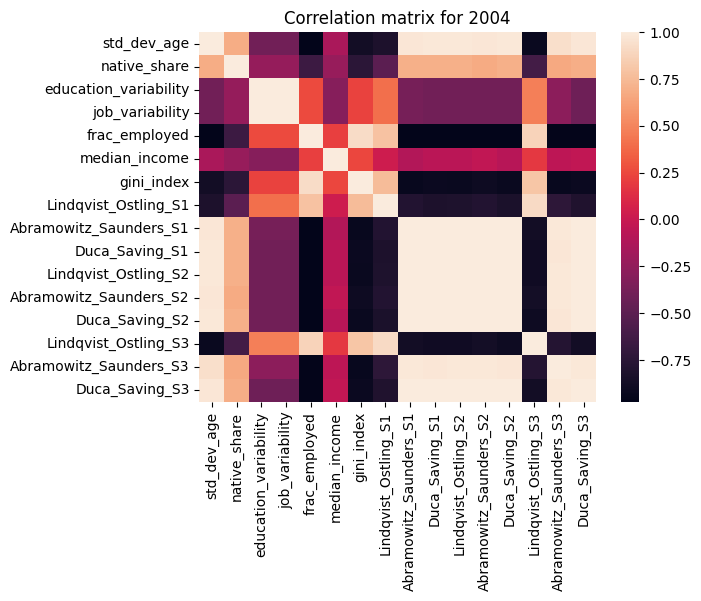

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = output_df.corr()
sns.heatmap(corr_matrix)
plt.title("Correlation matrix for 2004")
plt.show()

In [14]:
output_df.to_csv(r"polarization2004_data.csv")

In [15]:
df_residence.head(1)

,nopsocc,nopsocd,nopsoce,nfiyr,nfetype,nage12,njbstatt,nregion2,nplbornc_cc,nfetype_encoded,njbstatt_encoded,nopsocc_encoded,nopsocd_encoded,nopsoce_encoded
0,Strongly agree,Disagree,Disagree,45694.398438,inapplicable,70.0,Retired,London,inapplicable,-8,4,2,-1,-1


### Visualizing distribution of opinions for all statements

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 2004')

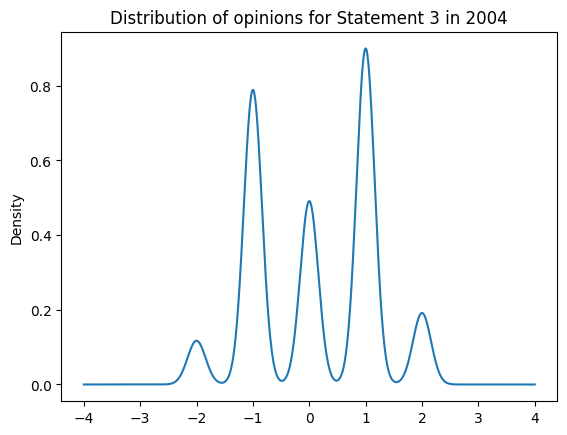

In [46]:
df_residence["nopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 2004")

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 2004')

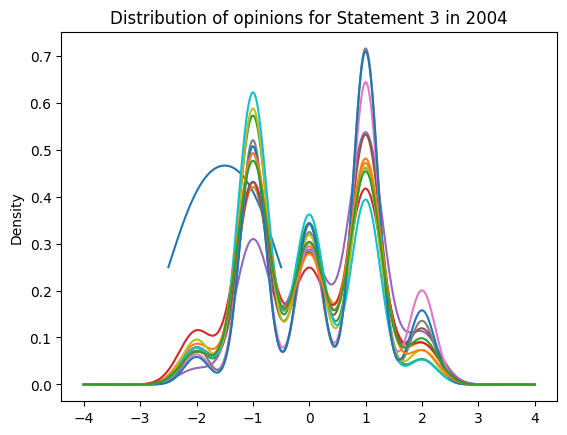

In [47]:
df_residence.groupby("nregion2")["nopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 2004")

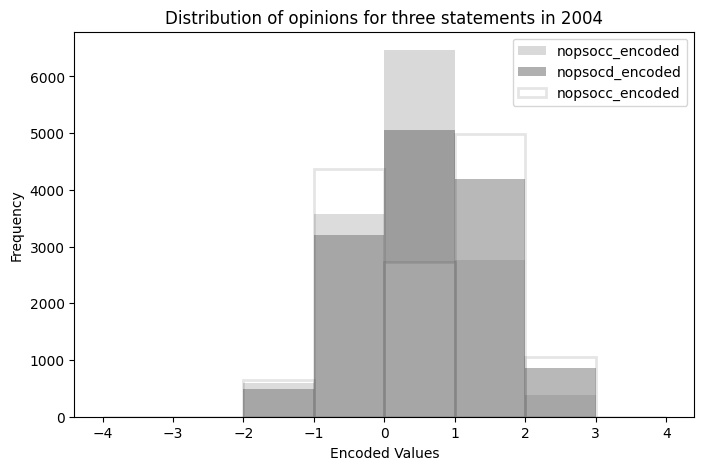

In [16]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(df_residence["nopsocc_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#d9d9d9')
ax.hist(df_residence["nopsocd_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#636363', alpha = 0.5)
ax.hist(df_residence["nopsoce_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='white', alpha = 0.1, edgecolor='black', linewidth = 2)

# set title and axis labels
ax.set_title('Distribution of opinions for three statements in 2004')
ax.set_xlabel('Encoded Values')
ax.set_ylabel('Frequency')

# add a legend
ax.legend(['nopsocc_encoded', 'nopsocd_encoded', 'nopsocc_encoded'], loc='upper right')

plt.show()

In [17]:
output_df.head(1)

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,27.428695,1.0,1.0,Channel Islands,1.0,0.0,10603.949219,0.312804,0.5,1.5,125.0,4.5,1.5,375.0,0.5,1.5,125.0


In [18]:
def lo(x):
    return round((x["Lindqvist_Ostling_S1"] + x["Lindqvist_Ostling_S2"] + x["Lindqvist_Ostling_S3"])/3, 1);
def As(x):
    return round((x["Abramowitz_Saunders_S1"] + x["Abramowitz_Saunders_S2"] + x["Abramowitz_Saunders_S3"])/3, 1);
def ds(x):
    return round((x["Duca_Saving_S1"] + x["Duca_Saving_S2"] + x["Duca_Saving_S3"])/3, 1);

output_df["Psd"] = output_df.apply(lambda x: lo(x), axis = 1)
output_df["Pid"] = output_df.apply(lambda x: As(x), axis = 1)
output_df["Pea"] = output_df.apply(lambda x: ds(x), axis = 1)

output_df.head(5)

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,Psd,Pid,Pea
0,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,125.000000,4.500000,1.500000,375.000000,0.500000,1.500000,125.000000,1.8,1.5,208.3
1,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,2.410976,0.891563,0.706147,2.305031,1.168530,0.912782,8.061817,0.9,0.7,4.3
2,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,2.233210,0.840264,0.697047,1.117012,1.013606,0.854942,2.416369,0.8,0.7,1.9
3,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,4.491054,0.995649,0.782875,3.072200,1.276732,0.966102,9.327323,1.0,0.8,5.6
4,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,0.292814,0.882639,0.706897,3.139223,1.028232,0.890173,1.449022,0.9,0.7,1.6


In [19]:
output_df["nPsd"] = (output_df["Psd"] - output_df["Psd"].min()) / (output_df["Psd"].max() - output_df["Psd"].min())
output_df["nPid"] = (output_df["Pid"] - output_df["Pid"].min()) / (output_df["Pid"].max() - output_df["Pid"].min())
output_df["nPea"] = (output_df["Pea"] - output_df["Pea"].min()) / (output_df["Pea"].max() - output_df["Pea"].min())

output_df.head(5)

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,...,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,Psd,Pid,Pea,nPsd,nPid,nPea
0,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,...,375.000000,0.500000,1.500000,125.000000,1.8,1.5,208.3,1.0,1.000,1.000000
1,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,...,2.305031,1.168530,0.912782,8.061817,0.9,0.7,4.3,0.1,0.000,0.013062
2,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,...,1.117012,1.013606,0.854942,2.416369,0.8,0.7,1.9,0.0,0.000,0.001451
3,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,...,3.072200,1.276732,0.966102,9.327323,1.0,0.8,5.6,0.2,0.125,0.019352
4,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,...,3.139223,1.028232,0.890173,1.449022,0.9,0.7,1.6,0.1,0.000,0.000000


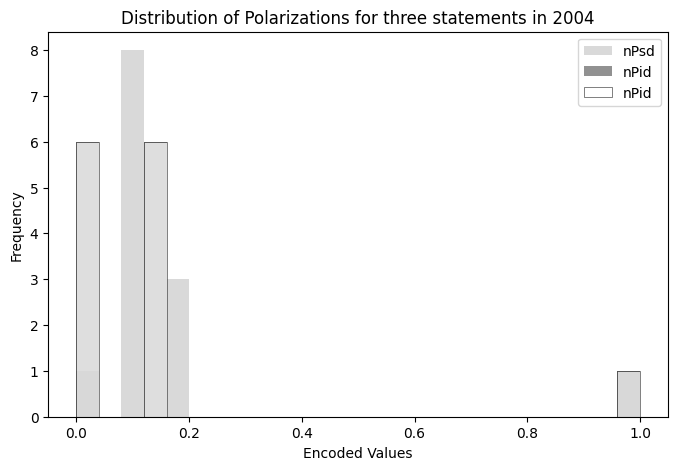

In [20]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(output_df["nPsd"], bins=25, color='#d9d9d9')
ax.hist(output_df["nPid"], bins=25, color='#252525', alpha = 0.5)
ax.hist(output_df["nPid"], bins=25, color='white', alpha = 0.7, edgecolor='black', linewidth = 0.5)

# set title and axis labels
ax.set_title('Distribution of Polarizations for three statements in 2004')
ax.set_xlabel('Encoded Values')
ax.set_ylabel('Frequency')

# add a legend
ax.legend(['nPsd', 'nPid', 'nPid'], loc='upper right')

plt.show()

In [21]:
output_df.corr()

,std_dev_age,native_share,education_variability,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,...,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,Psd,Pid,Pea,nPsd,nPid,nPea
std_dev_age,1.000000,0.676846,-0.395903,-0.395903,-0.967964,-0.146395,-0.879373,-0.822358,0.976073,0.979784,...,0.981028,-0.925701,0.934355,0.972036,0.944631,0.953813,0.979456,0.944631,0.953813,0.979456
native_share,0.676846,1.000000,-0.238103,-0.238103,-0.659297,-0.233030,-0.749382,-0.503894,0.692433,0.695284,...,0.697370,-0.624546,0.666394,0.689972,0.693464,0.622311,0.695944,0.693464,0.622311,0.695944
education_variability,-0.395903,-0.238103,1.000000,1.000000,0.254876,-0.305476,0.222702,0.401772,-0.375514,-0.399625,...,-0.395884,0.471881,-0.277126,-0.414343,-0.351179,-0.259831,-0.400442,-0.351179,-0.259831,-0.400442
job_variability,-0.395903,-0.238103,1.000000,1.000000,0.254876,-0.305476,0.222702,0.401772,-0.375514,-0.399625,...,-0.395884,0.471881,-0.277126,-0.414343,-0.351179,-0.259831,-0.400442,-0.351179,-0.259831,-0.400442
frac_employed,-0.967964,-0.659297,0.254876,0.254876,1.000000,0.209151,0.915859,0.791500,-0.973366,-0.973316,...,-0.973526,0.871133,-0.963840,-0.962058,-0.951466,-0.972259,-0.971652,-0.951466,-0.972259,-0.971652
median_income,-0.146395,-0.233030,-0.305476,-0.305476,0.209151,1.000000,0.240857,0.025331,-0.106462,-0.066579,...,-0.079531,0.182489,-0.050258,-0.039393,-0.026332,-0.120645,-0.068954,-0.026332,-0.120645,-0.068954
gini_index,-0.879373,-0.749382,0.222702,0.222702,0.915859,0.240857,1.000000,0.758697,-0.929952,-0.917069,...,-0.923184,0.803016,-0.928328,-0.916213,-0.920628,-0.900421,-0.921089,-0.920628,-0.900421,-0.921089
Lindqvist_Ostling_S1,-0.822358,-0.503894,0.401772,0.401772,0.791500,0.025331,0.758697,1.000000,-0.788894,-0.820737,...,-0.828351,0.910471,-0.738481,-0.810220,-0.724456,-0.738589,-0.823751,-0.724456,-0.738589,-0.823751
Abramowitz_Saunders_S1,0.976073,0.692433,-0.375514,-0.375514,-0.973366,-0.106462,-0.929952,-0.788894,1.000000,0.995786,...,0.996561,-0.880598,0.980434,0.994320,0.985043,0.981864,0.996445,0.985043,0.981864,0.996445
Duca_Saving_S1,0.979784,0.695284,-0.399625,-0.399625,-0.973316,-0.066579,-0.917069,-0.820737,0.995786,1.000000,...,0.999517,-0.894952,0.975335,0.997903,0.977595,0.973009,0.999785,0.977595,0.973009,0.999785
